In [147]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm

In [148]:
class_names = ['mancuernas', 'piano', 'skate']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

In [149]:
def load_data():
    
    datasets = ["./images/train", './images/test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [150]:
(train_images, train_labels), (test_images, test_labels) = load_data()


Loading ./images/train


100%|██████████| 180/180 [00:02<00:00, 77.35it/s]


Loading ./images/test


100%|██████████| 100/100 [00:01<00:00, 74.84it/s]


In [151]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [152]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 540
Number of testing examples: 300
Each image is of size: (150, 150)


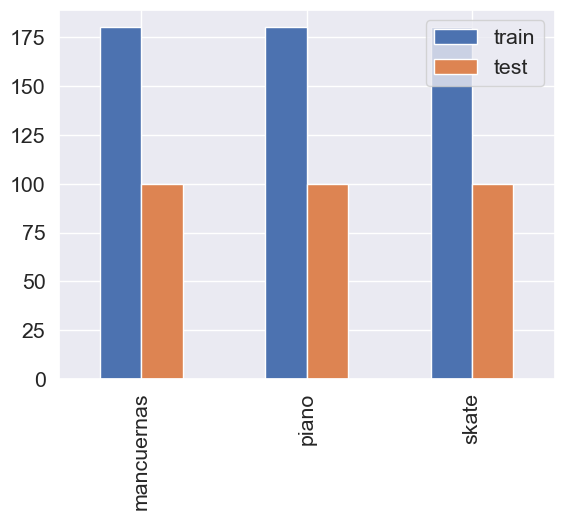

In [153]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

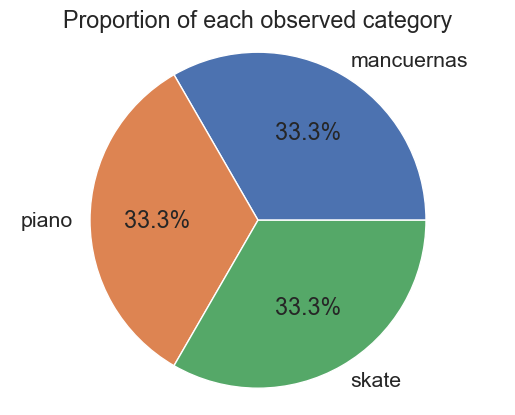

In [154]:
plt.pie(train_counts,
        explode=(0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [155]:
train_images = train_images / 255.0 
test_images = test_images / 255.0


In [156]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

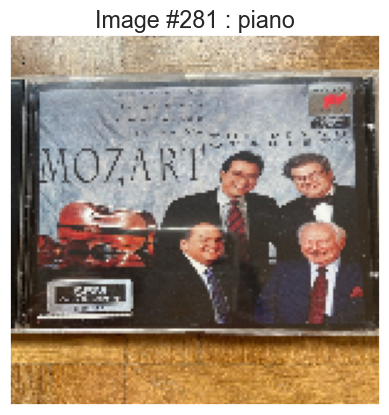

In [ ]:
display_random_image(class_names, train_images, train_labels)


In [158]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

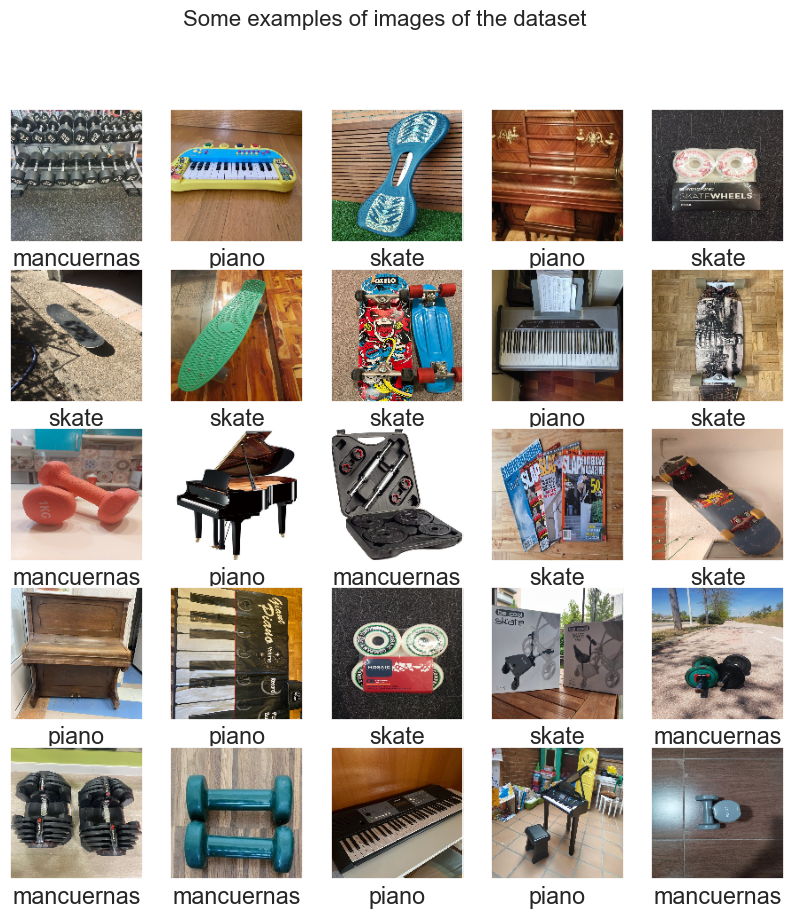

In [159]:
display_examples(class_names, train_images, train_labels)


In [160]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

In [161]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [163]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

Epoch 1/20
4/4 [==============================] - 6s 1s/step - loss: 0.8182 - accuracy: 0.6505 - val_loss: 1.6234 - val_accuracy: 0.3056
Epoch 2/20
4/4 [==============================] - 5s 1s/step - loss: 0.8906 - accuracy: 0.5903 - val_loss: 1.0613 - val_accuracy: 0.4537
Epoch 3/20
4/4 [==============================] - 5s 1s/step - loss: 0.7004 - accuracy: 0.7269 - val_loss: 1.1134 - val_accuracy: 0.4537
Epoch 4/20
4/4 [==============================] - 6s 1s/step - loss: 0.6087 - accuracy: 0.7940 - val_loss: 0.9553 - val_accuracy: 0.5463
Epoch 5/20
4/4 [==============================] - 6s 1s/step - loss: 0.5399 - accuracy: 0.8264 - val_loss: 0.9921 - val_accuracy: 0.5093
Epoch 6/20
4/4 [==============================] - 6s 2s/step - loss: 0.4387 - accuracy: 0.8565 - val_loss: 1.0302 - val_accuracy: 0.5278
Epoch 7/20
4/4 [==============================] - 6s 1s/step - loss: 0.3754 - accuracy: 0.8773 - val_loss: 1.1720 - val_accuracy: 0.5370
Epoch 8/20
4/4 [=========================

In [164]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['acc'],'bo--', label = "acc")
    plt.plot(history.history['val_acc'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

In [166]:
test_loss = model.evaluate(test_images, test_labels)


10/10 [==============================] - 1s 81ms/step - loss: 1.7448 - accuracy: 0.5100


10/10 [==============================] - 1s 88ms/step


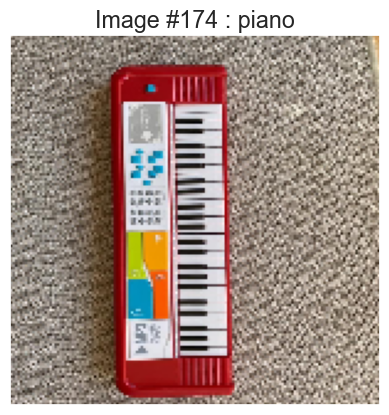

In [167]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(class_names, test_images, pred_labels)

In [168]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)

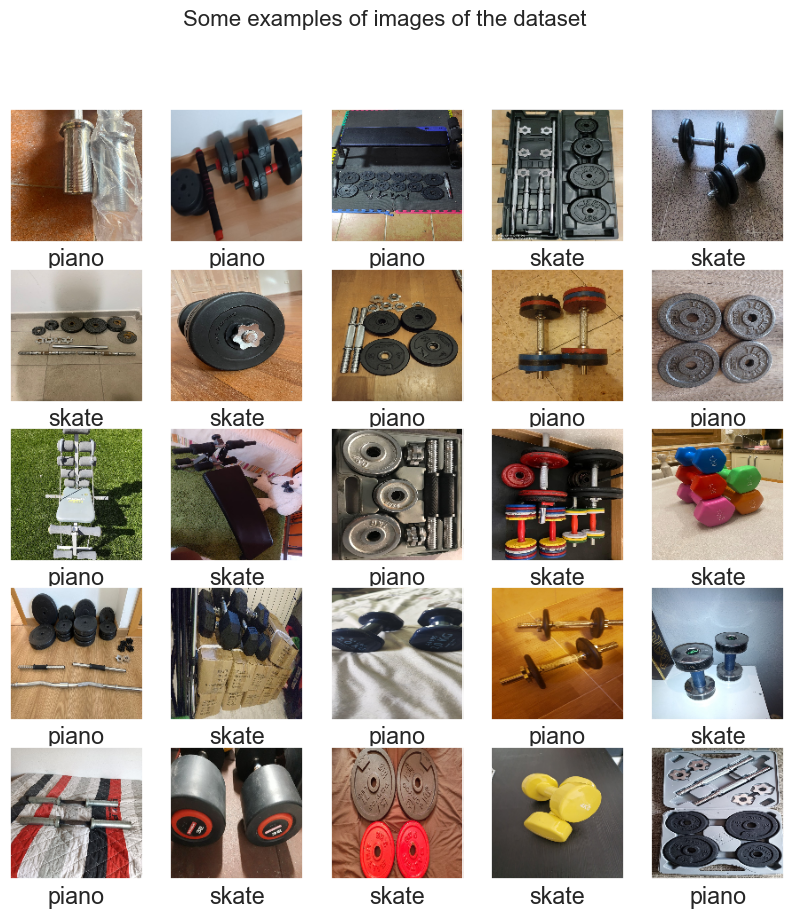

In [169]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)


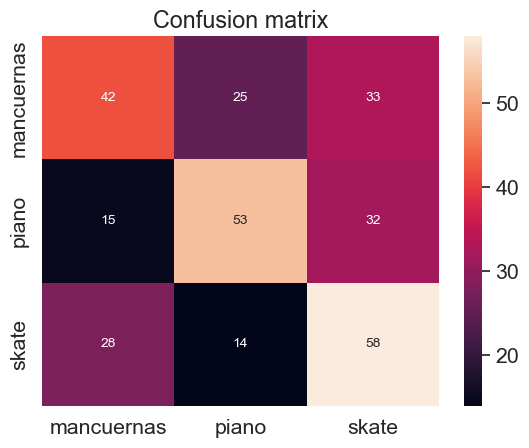

In [170]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [171]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

model = VGG16(weights='imagenet', include_top=False)

In [172]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

10/10 [==============================] - 19s 2s/step


In [173]:
n_train, x, y, z = train_features.shape
n_test, x, y, z = test_features.shape
numFeatures = x * y * z

In [174]:
from sklearn import decomposition

pca = decomposition.PCA(n_components = 2)

X = train_features.reshape((n_train, x*y*z))
pca.fit(X)

C = pca.transform(X) 
C1 = C[:,0]
C2 = C[:,1]

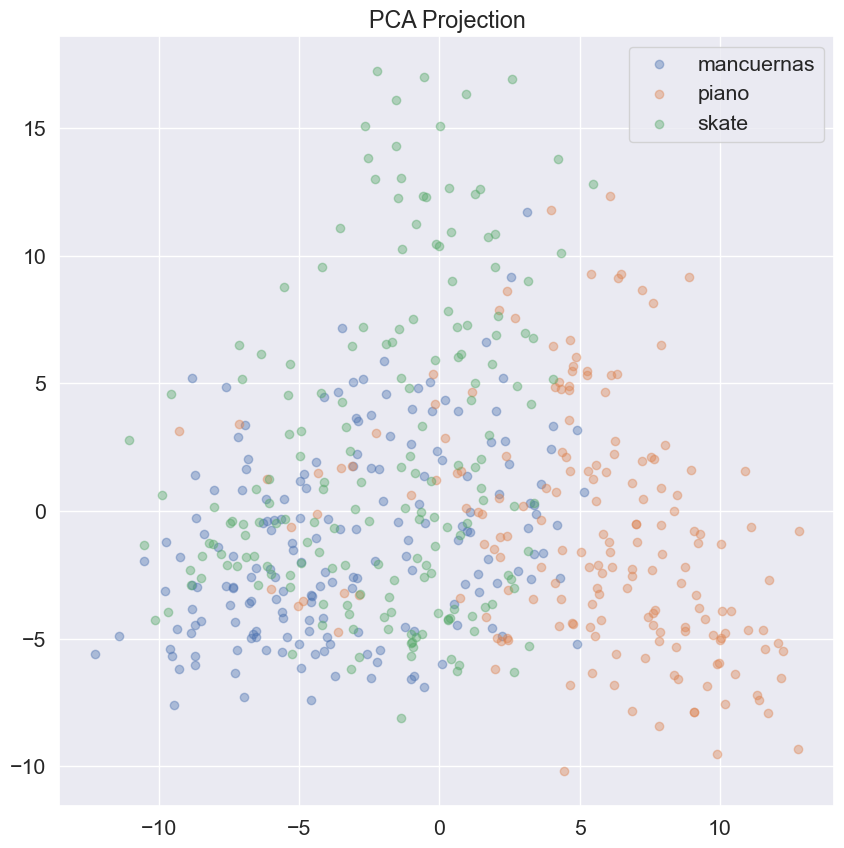

In [175]:
### Figures

plt.subplots(figsize=(10,10))

for i, class_name in enumerate(class_names):
    plt.scatter(C1[train_labels == i][:1000], C2[train_labels == i][:1000], label = class_name, alpha=0.4)
plt.legend()
plt.title("PCA Projection")
plt.show()

NameError: name 'C3' is not defined

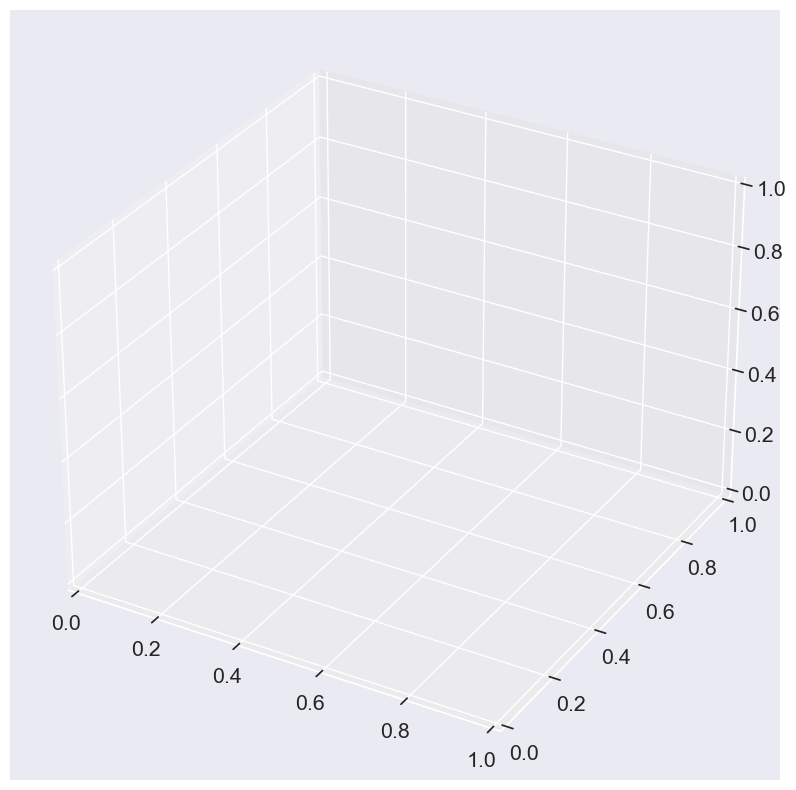

In [184]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

for i, class_name in enumerate(class_names):
    ax.scatter(C1[train_labels == i][:1000], C2[train_labels == i][:1000], C3[train_labels == i][:1000], label=class_name, alpha=0.4)
    
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend()
plt.title("PCA Projection in 3D")
plt.show()


In [176]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (x, y, z)),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

history2 = model2.fit(train_features, train_labels, batch_size=128, epochs=15, validation_split = 0.2)

Epoch 1/15
4/4 [==============================] - 1s 112ms/step - loss: 1.4938 - accuracy: 0.3495 - val_loss: 0.8642 - val_accuracy: 0.6296
Epoch 2/15
4/4 [==============================] - 0s 34ms/step - loss: 0.6561 - accuracy: 0.7500 - val_loss: 0.5685 - val_accuracy: 0.7685
Epoch 3/15
4/4 [==============================] - 0s 22ms/step - loss: 0.3992 - accuracy: 0.8611 - val_loss: 0.4925 - val_accuracy: 0.8056
Epoch 4/15
4/4 [==============================] - 0s 22ms/step - loss: 0.2877 - accuracy: 0.8889 - val_loss: 0.5381 - val_accuracy: 0.7963
Epoch 5/15
4/4 [==============================] - 0s 22ms/step - loss: 0.2258 - accuracy: 0.9306 - val_loss: 0.4619 - val_accuracy: 0.8056
Epoch 6/15
4/4 [==============================] - 0s 23ms/step - loss: 0.1582 - accuracy: 0.9630 - val_loss: 0.4678 - val_accuracy: 0.8241
Epoch 7/15
4/4 [==============================] - 0s 22ms/step - loss: 0.1251 - accuracy: 0.9676 - val_loss: 0.4648 - val_accuracy: 0.8148
Epoch 8/15
4/4 [==========

In [178]:
test_loss = model2.evaluate(test_features, test_labels)

10/10 [==============================] - 0s 3ms/step - loss: 0.4329 - accuracy: 0.8500


In [179]:
np.random.seed(seed=1997)
# Number of estimators
n_estimators = 10
# Proporition of samples to use to train each training
max_samples = 0.8

max_samples *= n_train
max_samples = int(max_samples)

In [180]:
models = list()
random = np.random.randint(50, 100, size = n_estimators)

for i in range(n_estimators):
    
    # Model
    model = tf.keras.Sequential([ tf.keras.layers.Flatten(input_shape = (x, y, z)),
                                # One layer with random size
                                    tf.keras.layers.Dense(random[i], activation=tf.nn.relu),
                                    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
                                ])
    
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Store model
    models.append(model)

In [181]:
histories = []

for i in range(n_estimators):
    # Train each model on a bag of the training data
    train_idx = np.random.choice(len(train_features), size = max_samples)
    histories.append(models[i].fit(train_features[train_idx], train_labels[train_idx], batch_size=128, epochs=10, validation_split = 0.1))

Epoch 1/10
4/4 [==============================] - 1s 85ms/step - loss: 1.4949 - accuracy: 0.3428 - val_loss: 0.9782 - val_accuracy: 0.5000
Epoch 2/10
4/4 [==============================] - 0s 28ms/step - loss: 0.5528 - accuracy: 0.7294 - val_loss: 0.8858 - val_accuracy: 0.7045
Epoch 3/10
4/4 [==============================] - 0s 28ms/step - loss: 0.3893 - accuracy: 0.8711 - val_loss: 0.5495 - val_accuracy: 0.7273
Epoch 4/10
4/4 [==============================] - 0s 26ms/step - loss: 0.2520 - accuracy: 0.9072 - val_loss: 0.5749 - val_accuracy: 0.8409
Epoch 5/10
4/4 [==============================] - 0s 30ms/step - loss: 0.2177 - accuracy: 0.9278 - val_loss: 0.5313 - val_accuracy: 0.7955
Epoch 6/10
4/4 [==============================] - 0s 26ms/step - loss: 0.1296 - accuracy: 0.9639 - val_loss: 0.3029 - val_accuracy: 0.8636
Epoch 7/10
4/4 [==============================] - 0s 26ms/step - loss: 0.1067 - accuracy: 0.9665 - val_loss: 0.2933 - val_accuracy: 0.9545
Epoch 8/10
4/4 [===========

In [182]:
predictions = []
for i in range(n_estimators):
    predictions.append(models[i].predict(test_features))
    
predictions = np.array(predictions)
predictions = predictions.sum(axis = 0)
pred_labels = predictions.argmax(axis=1)

10/10 [==============================] - 0s 3ms/step


In [183]:
from sklearn.metrics import accuracy_score
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels)))

Accuracy : 0.85
